<a href="https://colab.research.google.com/github/Simoni2412/Image-Classification/blob/main/CNN_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/drive/MyDrive/PLD_3_Classes_256/Training',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/drive/MyDrive/PLD_3_Classes_256/Testing',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/drive/MyDrive/PLD_3_Classes_256/Validation',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3251 files belonging to 3 classes.
Found 405 files belonging to 3 classes.
Found 416 files belonging to 3 classes.


In [40]:
class_names = training_dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

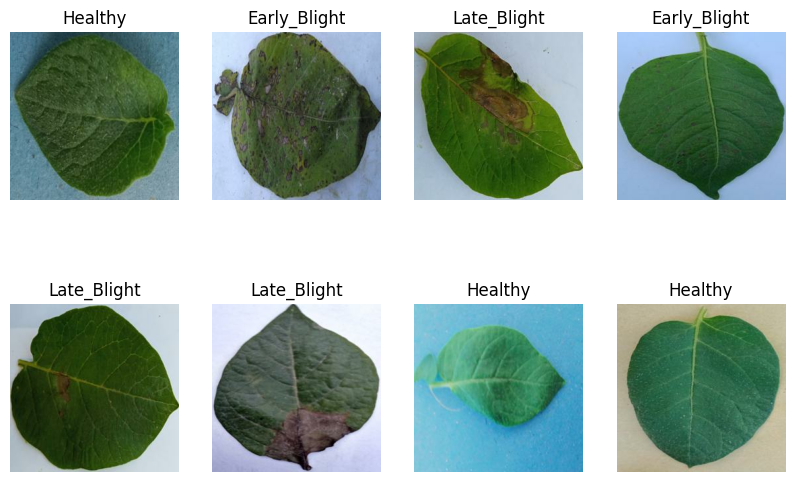

In [41]:
len(training_dataset)
plt.figure(figsize=(10,10))
for image_batch,label_batch in training_dataset.take(1):
    for i in range(0,8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [42]:

resize_scale = tf.keras.Sequential([
    # standardize values to be in the [0,1] range
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [43]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [44]:
#Using buffered prefetching to yield the data from having I/O blocking
train_data = training_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_data = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = testing_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
input_shape = (32, IMAGE_SIZE, IMAGE_SIZE, 3)

model = tf.keras.Sequential([
    resize_scale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(len(class_names),activation='softmax'),
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [46]:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [47]:
model_history = model.fit(
    train_data,
    epochs=20,
    batch_size=32,
    verbose=1,
    validation_data=validation_dataset,
    # callbacks=[callbacks]
)
score = model.evaluate(test_data)

Epoch 1/20
102/102 [==============================] - 18s 141ms/step - loss: 0.9911 - accuracy: 0.4928 - val_loss: 0.8300 - val_accuracy: 0.6370
Epoch 2/20
102/102 [==============================] - 12s 115ms/step - loss: 0.7925 - accuracy: 0.6684 - val_loss: 0.6368 - val_accuracy: 0.7572
Epoch 3/20
102/102 [==============================] - 12s 115ms/step - loss: 0.6775 - accuracy: 0.7315 - val_loss: 0.5713 - val_accuracy: 0.7812
Epoch 4/20
102/102 [==============================] - 12s 122ms/step - loss: 0.5486 - accuracy: 0.7994 - val_loss: 0.5353 - val_accuracy: 0.8077
Epoch 5/20
102/102 [==============================] - 12s 115ms/step - loss: 0.4137 - accuracy: 0.8514 - val_loss: 0.3255 - val_accuracy: 0.8870
Epoch 6/20
102/102 [==============================] - 12s 115ms/step - loss: 0.3438 - accuracy: 0.8853 - val_loss: 0.2714 - val_accuracy: 0.9111
Epoch 7/20
102/102 [==============================] - 12s 117ms/step - loss: 0.2446 - accuracy: 0.9182 - val_loss: 0.2612 - val_ac

In [48]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

In [49]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming model is your trained CNN model and test_data is your test dataset
# Make predictions on the test dataset
predictions = model.predict(test_data)

# Convert predicted probabilities into class labels
predicted_labels = np.argmax(predictions, axis=1)
test_label = np.concatenate([y for x, y in test_data], axis=0)
# Get true labels from the test dataset
true_labels = test_label  # Replace test_labels with your true labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display or analyze the confusion matrix as needed
print(conf_matrix)

13/13 [==============================] - 0s 22ms/step
[[150   5   7]
 [  4  94   4]
 [  1   1 139]]


In [50]:
TN = conf_matrix[0, 0]  # True Negatives
FP = conf_matrix[0, 1]  # False Positives
TP = conf_matrix[1, 1]  # True Positives
FN = conf_matrix[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
specificity, sensitivity

(0.967741935483871, 0.9591836734693877)

Text(0.5, 1.0, 'Training and Validation Accuracy')

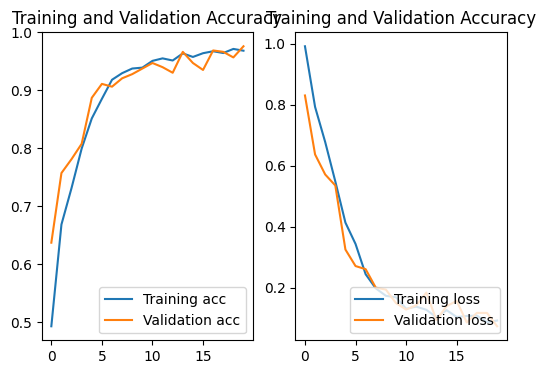

In [52]:
plt.figure(figsize=(6,4))
plt.subplot(1,2,1)
plt.plot( range(20) , acc , label="Training acc" )
plt.plot( range(20) , val_acc , label="Validation acc" )
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot( range(20) , loss , label="Training loss" )
plt.plot( range(20) , val_loss , label="Validation loss" )
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')

The Image Title :  Late_Blight
1/1 [==============================] - 0s 29ms/step
Model Predicted label :  Late_Blight


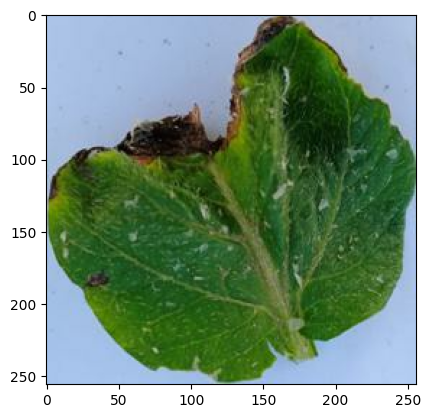

In [54]:
for image_batch,label_batch in test_data.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    print("The Image Title : ",class_names[label_batch[0].numpy()])
    prediction = model.predict(image_batch)
    print("Model Predicted label : ",class_names[np.argmax(prediction[0])])


In [21]:
model.save("Potato-Disease_Classification.h5")
from tensorflow.keras.models import load_model

# load model
model = load_model('Potato-Disease_Classification.h5')

# check model info
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 